In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#print options to data exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To begin forming our linear regression models we load in our imputed data set.

In [34]:
personal_path = '/content/drive/My Drive/'
path_full = os.path.join(personal_path, "biweekly_imputed_old.csv")
df = pd.read_csv(path_full)

For our first model the reponse will be the number of new Covid cases per million people on a particular day in a particular country. For now we not interested in predicting the reponse of future data points, rather we are interested in direct interpretation of the regression coefficients. Therefore, we forgo splitting the data into a train and test set. 

Therefore, we also drop irrelevant/unineteresting features. For example, having the positive rate of Covid tests on a particular day will indeed be useful for predicting the number of new cases but this relationship is fundamentally obvious.

We hope most of the predictor names are sufficiently descriptive. One point of clarification is for the variant predictors such as Alpha, Mu, Delta, etc. the values correspond to proportion of cases in a specific country on a specific date attributed to each variant. Thus, the sum of the variant data should be 1 for every country on every date.

In [35]:
y = df['new_cases_smoothed_per_million']
X = df.drop(['Unnamed: 0', 'new_cases_smoothed_per_million', 'date', 'total_cases_per_million','total_deaths_per_million','new_deaths_smoothed_per_million','total_tests_per_thousand','positive_rate','tests_per_case','hospital_beds_per_thousand','icu_patients_per_million','hosp_patients_per_million','iso_code','month_yr','population','reproduction_rate','new_tests_smoothed_per_thousand'], axis = 1)

Next, we examine the correlation between features in our data set. Recall that in a an Ordinary Least Squares Linear Regression we assume $Y_i = \beta_0 + \beta_1x_1 + \beta_1x_1 +\ldots + \beta_kx_k + ϵ_i$ where we have $k$ features and $\epsilon ~ \sim \mathcal{N}(0, \sigma^2)$. Under these assumptions the associated likelihhod is $\prod_i^n p(\vec{x_i})\cdot \frac{1}{(2\sigma^2\pi)^{\frac{1}{2}}} \cdot exp\{-\frac{(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2}{2\sigma^2}\}$ and it can be shown that maximing this expression as a function of $\vec{\beta}$ is equivalent to minimizing $\sum_{i=1}^n(y_i-(\beta_0 + \sum_{j=1}^k\beta_jx_{ij}))^2$ in terms of $\vec{\beta}$. From here it follows that the regression coefficients can solved in closed form as $\hat{\vec{\beta}} = (X^TX)^{-1}X^TY$ where $X$ is our design matrix (matrix of predictors + a column of 1s for an intercept term) and $Y$ is our vector of responses. Note that $\hat{\vec{\beta}}$ depends on $(X^TX)^{-1}$ and that the latter expression will not be invertible if the columns of features are linearly dependent. Thus, if the columns of the design matrix are linearly dependent the OLS estimates for the coefficients cannot be solved for. Furthermore, by noting that $\hat{\vec{\beta}} \sim \mathcal{N}(0, (X^TX)^{-1}\sigma^2)$ we see that large values in $(X^TX)^{-1}$ will cause our coefficient estimates to be highly variable. Thus, we must also be careful to ensure that our design matrix is not near singluar as such a design matrix would yeild abnormally large values in $(X^TX)^{-1}$ and cause our estimates to be highly variable. To avoid this situation we analyze a correlation matrix of our features. Having features that are highly correlated will result in $(X^TX)^{-1}$ being near singular and so if a pair of features is highly correlated we will remove one of them. The plot below visualizes our correlation matrix. We are concerned about off-diagonal cells which are light green/yellow.

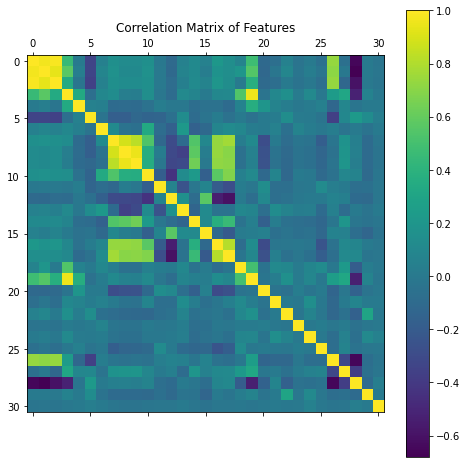

In [36]:
plt.figure(figsize=(8, 8))
plt.matshow(X.corr(), fignum = 1)
plt.colorbar()
plt.title('Correlation Matrix of Features')
plt.show()

We now drop the highly correlated predictors from our design matrix. We use a threshold of 0.8 to identify highly correlated pairs.

In [37]:
X.drop(['non_who','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','daily_vaccinations_per_million','new_people_vaccinated_smoothed_per_hundred','life_expectancy','aged_70_older','human_development_index'], axis = 1, inplace = True)

We now fit our initial linear regression model. We display some verbose output from the regression below and analyze it in proceeding cell.

In [38]:
import statsmodels.api as sm

#add a column of ones for the intercept term
X_full = sm.add_constant(X)
est_full = sm.OLS(y, X_full)
est_full_fit = est_full.fit()
print(est_full_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.156
Model:                                        OLS   Adj. R-squared:                  0.147
Method:                             Least Squares   F-statistic:                     17.58
Date:                            Fri, 10 Dec 2021   Prob (F-statistic):           7.25e-65
Time:                                    00:48:28   Log-Likelihood:                -14732.
No. Observations:                            2211   AIC:                         2.951e+04
Df Residuals:                                2187   BIC:                         2.965e+04
Df Model:                                      23                                         
Covariance Type:                        nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

The first value to consider is the $R^2$ value. This is a measure of goodeness of fit and is defined as $R^2=1-\frac{\sum_{i=1}^n(y_i-\hat{y_i})^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$. Evidently the closer $R^2$ is to 1 the better the model is at explaining the response. We will consider the adjusted $R^2$ value which penalizes for having many predictors. Such a penalty is logical since adding predictors to a linear regression model will only help its explanatory abaility even if the added predictor is completly irrelavent. For our model $Adj. R^2 = 0.147$ which is rather low. Such a value can roughly be interpreted as meaning that the predictor variables account for 14.7% of the variability in the response variable. Nonetheless the model is not worthless. The $F-Test$ for overall model utility which as null hypothesis $H_0:$ our model and a model consisting of only an intercept term have the same explanatory capability, as a near zero p-value. Thus, we can conclude that the predictors do indeed have an effect on the response but they do not tell the entire story. We can always examine $t-tests$ for individual predictors. Each such test has the null hypothesis $H_0:$ the coefficient associated with the predictor is 0. Thus, if the p-value of such a test is large the predictor may not have any influence on the response and may be able to be removed without hindering the model. In our model, if we conduct the test at a 95% confidence level, the insignificant predictors are total vaccinations per hundred, new vaccinations smoothed per million, extreme poverty, diabetes prevalence, male smokers, daily people vaccinated per hundred, Beta, Kappa, Iota, Eta, Alpha, Lambda, and Mu. we now fit a model with these predictors removed and check to see if we can safetly justify their removal.

In [39]:
from statsmodels.stats.anova import anova_lm
X_nested = X.drop(['total_vaccinations_per_hundred','new_vaccinations_smoothed_per_million','extreme_poverty','diabetes_prevalence','male_smokers','daily_people_vaccinated_per_hundred','Beta','Kappa','Iota','Eta','Alpha','Lambda','Mu'], axis = 1)
X_nested = sm.add_constant(X_nested)
est_nested = sm.OLS(y, X_nested)
est_nested_fit = est_nested.fit()
print(anova_lm(est_nested_fit, est_full_fit))

   df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
0    2200.0  7.991258e+07      0.0            NaN       NaN       NaN
1    2187.0  7.932728e+07     13.0  585299.198178  1.241254  0.242846


The above output details an $F-Test$ for nested linear regression models. The null hypothesis is $H_0:$ all coeffcients present in the full model but not the nested model are 0$. In other words the hypothesis test is detirmining if the nested model accounts for the just as much variance in the reponse as the full model. In our case the p-value is 0.243 and so we fail to reject th null hypothesis and we can justifiably reduce the model. We now exmaine the coefficients of this nested model.


In [40]:
print(est_nested_fit.summary())

                                  OLS Regression Results                                  
Dep. Variable:     new_cases_smoothed_per_million   R-squared:                       0.150
Model:                                        OLS   Adj. R-squared:                  0.146
Method:                             Least Squares   F-statistic:                     38.76
Date:                            Fri, 10 Dec 2021   Prob (F-statistic):           9.69e-71
Time:                                    00:49:57   Log-Likelihood:                -14740.
No. Observations:                            2211   AIC:                         2.950e+04
Df Residuals:                                2200   BIC:                         2.956e+04
Df Model:                                      10                                         
Covariance Type:                        nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]


Interpreting regression coefficients can be tricky. One needs to resist the temptation to fit a narraive to explain the why the coefficients take on certain values. For example, strigency_index is a metric developed by Our World in Data, that attempts to quantify how many restrictions a country has put in place to slow the spread of Covid-19. Countries with mask mandates, travel bans, and mandatory quarantines will have a higher strigency index than those countries which do not. The regression coefficient associated with strigency index is 3.0802, suggesting that the more restrictions a government puts in place the more Covid-19 spreads. Of course the true relationship is likely that the governments of countries in which there is a COVID-19 outbreak, and thus lots of new cases, are more likely to implement restrictive measures to slow the spread. Other interesting